In [429]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(123)
tf.random.set_seed(123)

In [430]:
df = pd.read_csv('sp500sub.csv', index_col = 0, parse_dates = True)

In [465]:
# Taking GOOGLE Close Prices

Google = df[df['Name'] == 'GOOG'][['Close']].copy() 

In [432]:
Google.head()

,Close
Date,
2010-01-04,312.204773
2010-01-05,310.829926
2010-01-06,302.994293
2010-01-07,295.940735
2010-01-08,299.885956


<Axes: xlabel='Date'>

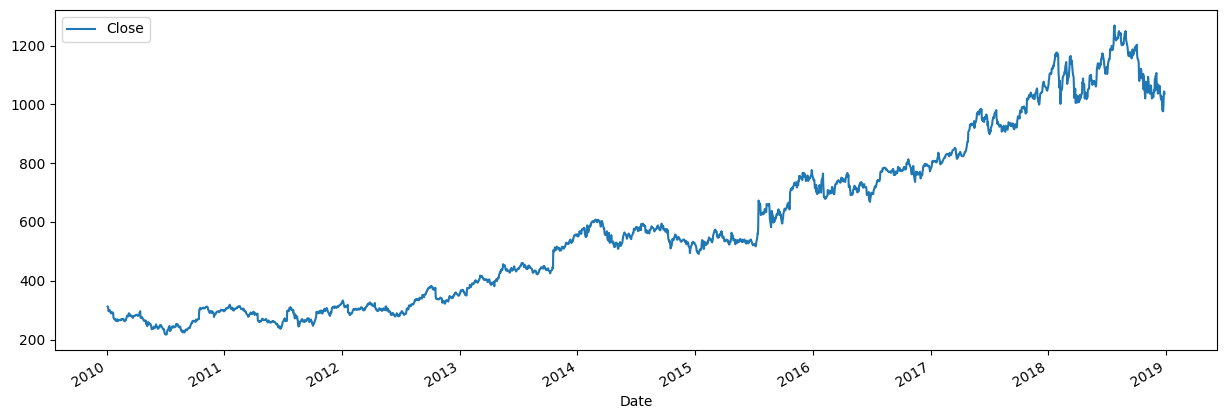

In [433]:
Google.plot(figsize = (15,5))

In [434]:
Google['log_Close'] = np.log(Google['Close'])

<Axes: xlabel='Date'>

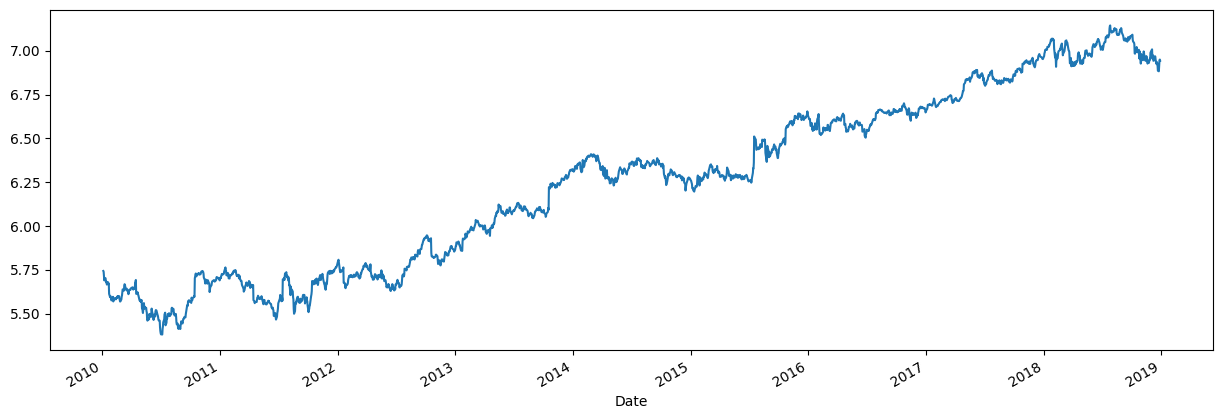

In [435]:
Google['log_Close'].plot(figsize = (15,5))

In [436]:
# Deriving Function for Checking stationarity through Augmented Dicky-Fuller Test

def check_stationarity(a):
    adf = adfuller(a)
    if adf[1] < 0.05 and adf[0] < adf[4]['1%']:
        print('The data is stationary')
        print('ADF-Value: ', adf[0])
        print('P-Value: ', adf[1])
    else:
        print('The data is non-stationary')
        print('ADF-Value: ', adf[0])
        print('P-Value: ', adf[1])

In [437]:
check_stationarity(Google['log_Close'])

The data is non-stationary
ADF-Value:  -0.4181902578906113
P-Value:  0.907017067749841


In [438]:
Google['Diff_Log_Close'] = Google['log_Close'].diff()

In [439]:
check_stationarity(Google['Diff_Log_Close'].dropna())

The data is stationary
ADF-Value:  -46.66748022773676
P-Value:  0.0


<Axes: xlabel='Date'>

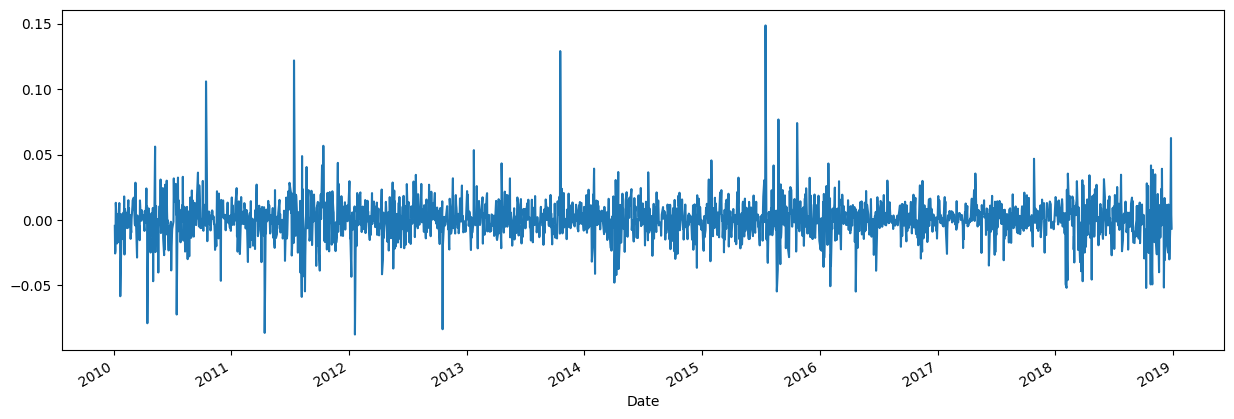

In [440]:
Google['Diff_Log_Close'].plot(figsize = (15,5))

In [441]:
# Splitting data into Training(70%) and Testing(30%) sets

Ntest = 678
train = Google.iloc[: -Ntest]
test = Google.iloc[-Ntest :]

In [442]:
# Transforming training and testing data sets by scaling 

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['Diff_Log_Close']])
test_scaled = scaler.transform(test[['Diff_Log_Close']])

In [443]:
# Creating boolean series to index df rows

train_idx = Google.index <= train.index[-1]
test_idx = Google.index > train.index[-1]

In [444]:
Google.loc[train_idx, 'Scaled_Log_Return'] = train_scaled.flatten()
Google.loc[test_idx, 'Scaled_Log_Return'] = test_scaled.flatten()

In [445]:
# Making supervised dataset

series = Google['Scaled_Log_Return'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2252, 10, 1) Y.shape (2252,)


In [446]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [447]:
# RNN
i = Input(shape=(T, 1))
x = LSTM(24)(i)
x = Dense(1)(x)
model = Model(i, x)

In [448]:
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 10, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 24)                  │           2,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,521 (9.85 KB)

 Trainable params: 2,521 (9.85 KB)

 Non-trainable params: 0 (0.00 B)

In [449]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [450]:
r = model.fit( Xtrain, Ytrain, epochs=100, validation_data=(Xtest, Ytest))

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0477 - val_loss: 0.7186
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0345 - val_loss: 0.7154
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0323 - val_loss: 0.7148
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0311 - val_loss: 0.7144
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0301 - val_loss: 0.7141
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0293 - val_loss: 0.7139
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0285 - val_loss: 0.7136
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0278 - val_loss: 0.7134
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0271 - val_loss: 0.7133
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0264 - val_loss: 0.7132
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0256 - val_loss: 0.7131
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0

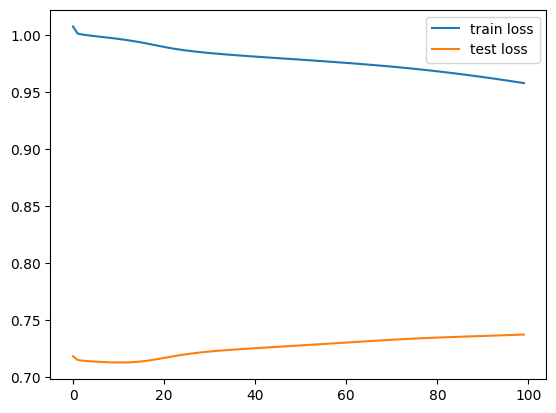

In [451]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [452]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [453]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

Ptrain = scaler.inverse_transform(Ptrain).flatten()
Ptest = scaler.inverse_transform(Ptest).flatten()

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


In [454]:
# Storing differenced predictions

Google.loc[train_idx, 'Diff_Train_Pred'] = Ptrain
Google.loc[test_idx, 'Diff_Test_Pred'] = Ptest

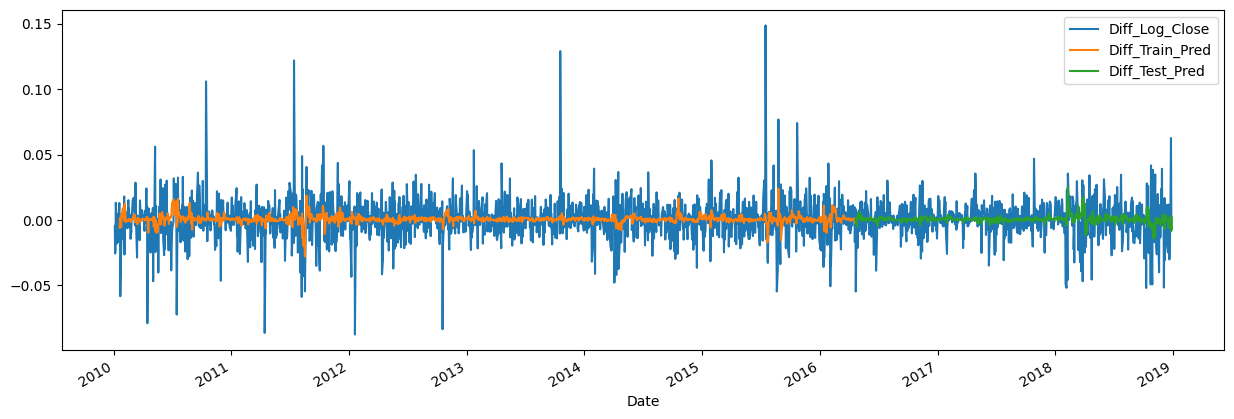

In [455]:
cols = ['Diff_Log_Close', 'Diff_Train_Pred', 'Diff_Test_Pred']
Google[cols].plot(figsize=(15, 5));

In [456]:
# Need to compute un-differenced predictions

Google['Shift_Log_Close'] = Google['log_Close'].shift(1)
prev = Google['Shift_Log_Close']

In [457]:
last_train = train.iloc[-1]['log_Close']

In [458]:
# 1-step forecast

Google.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
Google.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

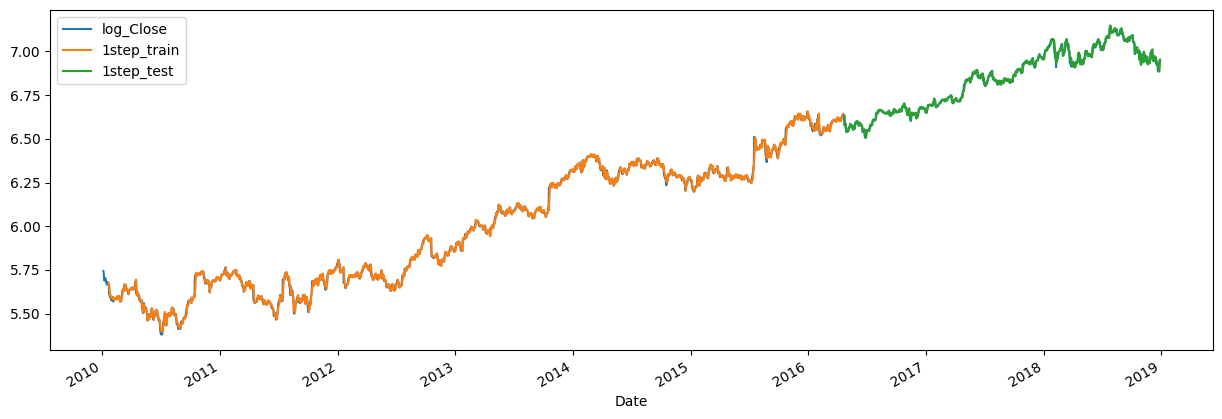

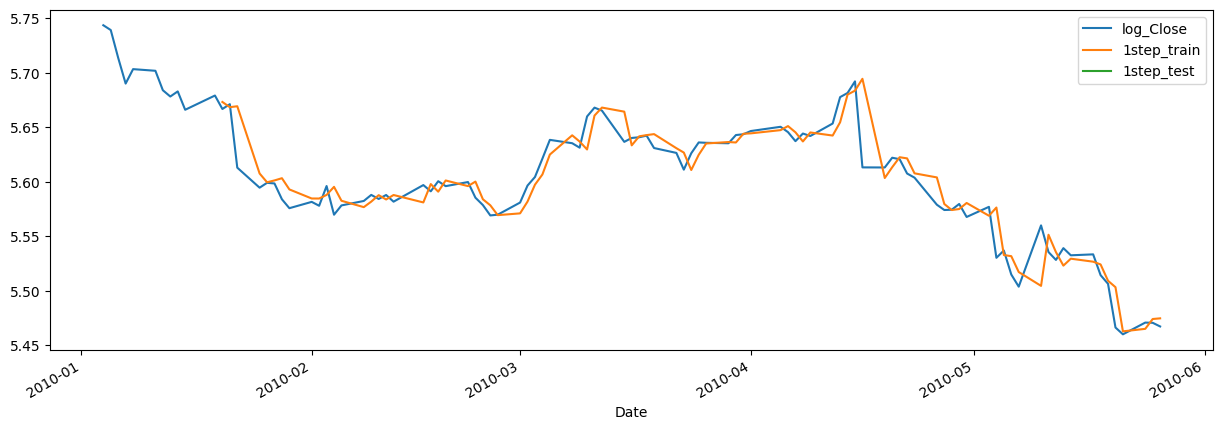

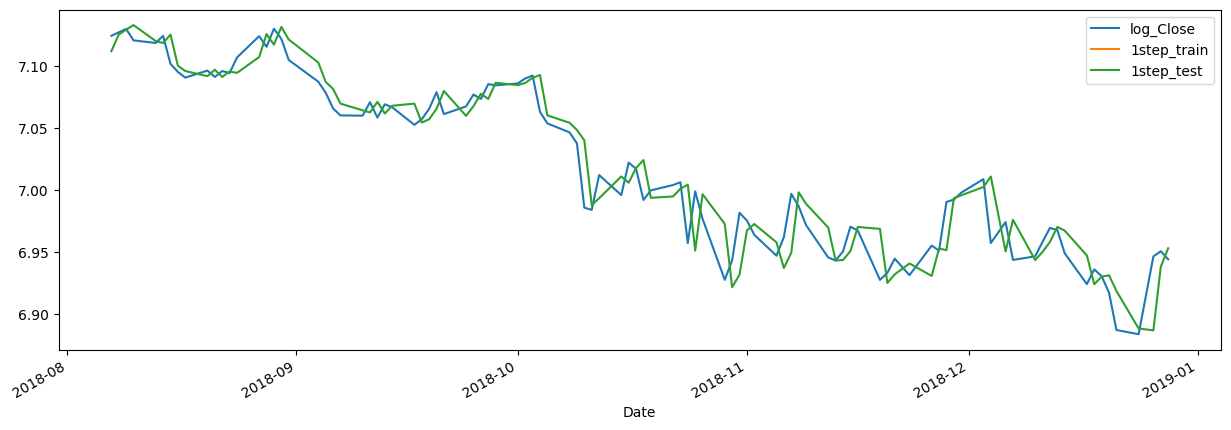

In [459]:
Google[['log_Close', '1step_train', '1step_test']].plot(figsize=(15, 5));
Google.iloc[:100][['log_Close', '1step_train', '1step_test']].plot(figsize=(15, 5));
Google.iloc[-100:][['log_Close', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [460]:
# Multi-step forecast

multistep_predictions = []

last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1, 1))[0]
  multistep_predictions.append(p)
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

In [461]:
multistep_predictions = np.array(multistep_predictions)
multistep_predictions = scaler.inverse_transform(multistep_predictions.reshape(-1, 1)).flatten()

In [462]:
Google.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

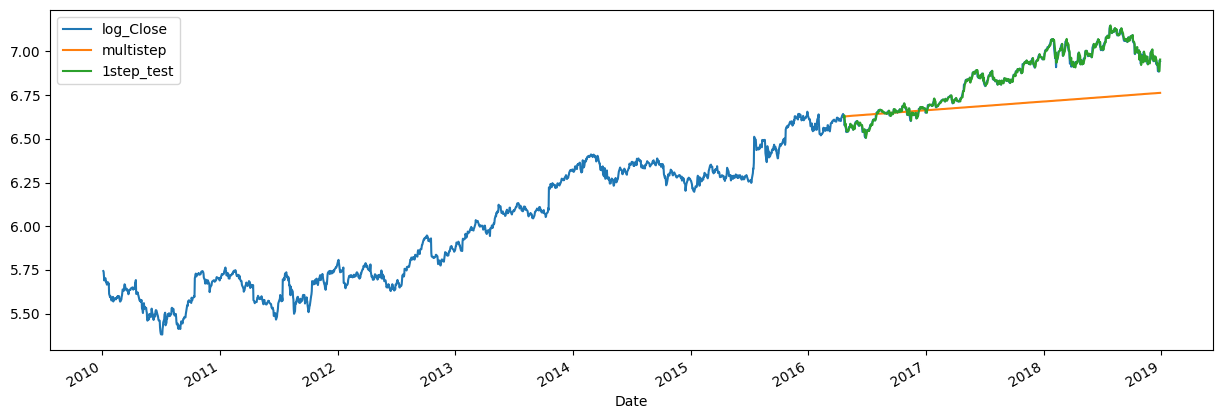

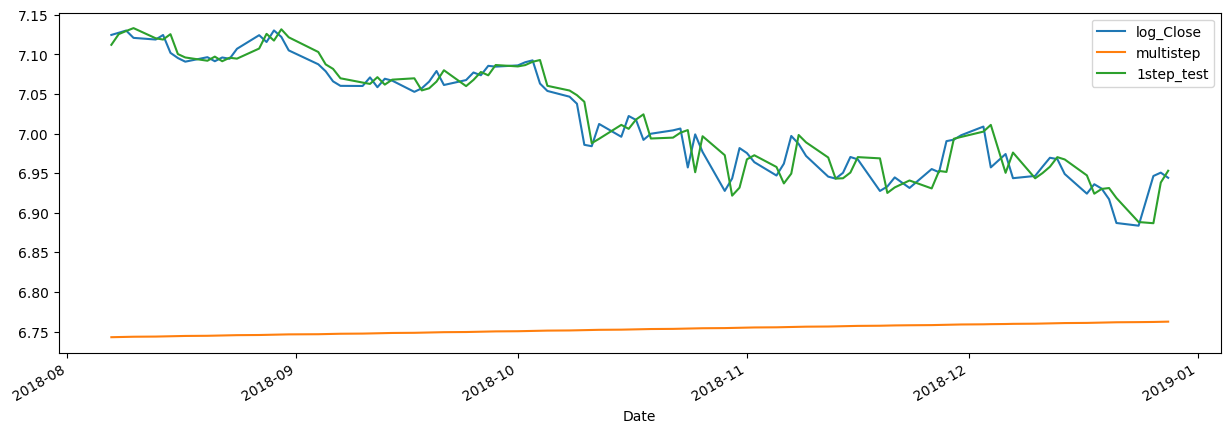

In [463]:
Google[['log_Close', 'multistep', '1step_test']].plot(figsize=(15, 5));
Google.iloc[-100:][['log_Close', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [464]:
# MAPE
test_log_pass = Google.loc[test_idx, 'log_Close']
mape1 = mean_absolute_percentage_error(
    test_log_pass, Google.loc[test_idx, '1step_test'])
print("1step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, Google.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape2)

1step MAPE: 0.0013902923279639815
multi-step MAPE: 0.023074956997222146


We can see that 1step Forcast model is much better in this case.